In [0]:
# パッケージ のインポート
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

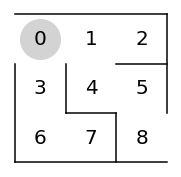

In [2]:
# 迷路の作成
fig = plt.figure(figsize=(3,3))

# 壁
plt.plot([0,3], [3,3], color='k') # 第一引数はx軸、第二引数はy軸における、線分の端点の座標
plt.plot([0,3], [0,0], color='k')
plt.plot([0,0], [0,2], color='k')
plt.plot([3,3], [1,3], color='k')
plt.plot([1,1], [1,2], color='k')
plt.plot([2,3], [2,2], color='k')
plt.plot([2,1], [1,1], color='k')
plt.plot([2,2], [1,0], color='k')


# 数字
for i in range(3):
  for j in range(3):
    plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center', va='center')

# 円
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

# 目盛りと枠の非表示
plt.tick_params(
    bottom=False, top=False ,
    labelbottom=False, right=False, left=False, labelleft=False
)

plt.box(False)

In [0]:
# パラメータθの初期値の準備
theta_0 = np.array([
  [np.nan, 1, 1, np.nan], # 0 上、右、下、左
  [np.nan, 1, 1, 1], # 1
  [np.nan, np.nan, np.nan, 1], # 2
  [1, np.nan, 1, np.nan], # 3
  [1, 1, np.nan, np.nan], # 4
  [np.nan, np.nan, 1, 1], # 5
  [1, 1, np.nan, np.nan], # 6
  [np.nan, np.nan, np.nan, 1], # 7
])

In [0]:
# パラメータθを方策に変換
def get_pi(theta):
  # 割合の計算
  [m, n] = theta.shape
  pi =np.zeros([m, n])
  for i in range(0, m):
    pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
  pi = np.nan_to_num(pi)

  return pi

In [5]:
# パラメータθの初期値を方策に変換
pi_0 = get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [0]:
# 行動に従って次の状態を取得
def get_s_next(s, a):
  if a == 0:
    return s-3
  elif a == 1:
    return s+1
  elif a == 2:
    return s+3
  elif a == 3:
    return s-1

In [7]:
# 行動価値関数の準備：学習前は正しい「行動価値関数」がわかっていないので、移動可な方向は乱数、移動不可な方向はnp.nanで初期化
[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0
print(Q)

[[       nan 0.98831379 0.3764356         nan]
 [       nan 0.06206606 0.0781572  0.69659216]
 [       nan        nan        nan 0.67882881]
 [0.9177077         nan 0.49327731        nan]
 [0.03815942 0.08906333        nan        nan]
 [       nan        nan 0.36983378 0.72911575]
 [0.47139928 0.35661115        nan        nan]
 [       nan        nan        nan 0.46631177]]


In [0]:
# ランダムまたは行動価値関数に従って行動を取得
def get_a(s, Q, epsilon, pi_0):
  if np.random.rand() < epsilon:
    # ランダムに行動を選択
    return np.random.choice([0,1,2,3], p=pi_0[s])
  else:
    #行動価値関数で行動を選択
    return np.nanargmax(Q[s])

In [0]:
# Sarsaによる行動価値関数の更新
def sarsa(s, a, r, s_next, a_next, Q):
  eta = 0.1 # 学習係数
  gamma = 0.9 # 時間割引率

  if s_next == 8:
    Q[s, a] = Q[s, a] + eta * (r - Q[s,a])
  else:
    Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

  return Q

In [0]:
# Q学習による行動価値関数の更新
def q_learning(s, a, r, s_next, Q):
  eta = 0.1
  gamma = 0.9

  if s_next == 8:
    Q[s, a] = Q[s, a] + eta * (r - Q[s,a])
  else:
    Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanargmax(Q[s_next, :]) - Q[s, a])

  return Q

In [0]:
# １エピソードの実行
def play(Q, epsilon, pi):
  s = 0 # 状態
  a = a_next = get_a(s, Q, epsilon, pi) # 行動の初期値

  s_a_history = [[0, np.nan]] # 状態と行動の履歴

  # エピソード完了までループ
  while True:
    # 行動に従って次の状態を取得
    a = a_next
    s_next = get_s_next(s, a)

    # 履歴の更新
    s_a_history[-1][1] = a
    s_a_history.append([s_next, np.nan])

    # 終了判定
    if s_next == 8:
      r = 1
      a_next = np.nan
    else:
      r = 0
      #　行動価値関数に従って行動の取得
      a_next = get_a(s_next, Q, epsilon, pi)

    # 行動価値関数の更新
    Q = sarsa(s, a, r, s_next, a_next, Q)

    # 終了判定
    if s_next == 8:
      break
    else:
      s = s_next

  return [s_a_history, Q]

In [13]:
epsilon = 0.5 # ε-greedy法のεの初期値

# エピソードを繰り返し実行して学習
for episode in range(10):
  # １エピソード実行して履歴と行動価値関数を取得
  [s_a_history, Q] = play(Q, epsilon, pi_0)

  # ε-greedyの値を小さくしていく
  epsilon /= 2

  # 出力
  print('エピソード: {}, ステップ: {}'.format(episode, len(s_a_history) - 1))

エピソード: 0, ステップ: 22
エピソード: 1, ステップ: 16
エピソード: 2, ステップ: 186
エピソード: 3, ステップ: 574
エピソード: 4, ステップ: 46
エピソード: 5, ステップ: 262
エピソード: 6, ステップ: 10
エピソード: 7, ステップ: 4
エピソード: 8, ステップ: 4
エピソード: 9, ステップ: 4


In [14]:
# アニメーションの定期処理を行う関数
def animate(i):
  state = s_a_history[i][0]
  circle.set_data((state % 3) + 0.5, 2.5 - (state // 3))
  return circle

# アニメーションの表示
anim = animation.FuncAnimation(fig, animate, \
          frames=len(s_a_history), interval=200, repeat=False
          )

HTML(anim.to_jshtml())